# ME5204 Finite Element Analysis
## Project 2D Plane Stress Problems
### SENTHILKUMAR R (ME22M016)

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#### Problem Definition

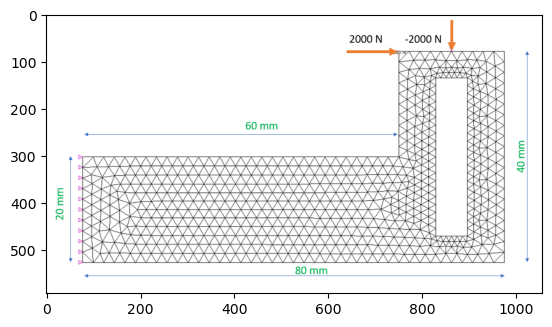

In [2]:
img = Image.open('problem_definition.png')
plt.imshow(img)

#### Analysis Input

In [3]:
Num_Nodes, Num_Elems, Num_Mats, Prob_Type, Thickness = np.loadtxt("./input.txt").astype(np.float32)

Num_Nodes, Num_Elems, Num_Mats, Prob_Type = int(Num_Nodes), int(Num_Elems), int(Num_Mats), int(Prob_Type)


#### Nodal Co-ordinate and Array

In [4]:
COORD = np.loadtxt("./COORD.txt").astype(np.float32)

In [5]:
NCA = np.loadtxt("./NCA.txt").astype(np.int32)
#print(NCA)

#### Material Property

In [6]:
MAT = np.loadtxt("./MAT.txt").astype(np.float32)
#print(MAT)

#### Equivalent Nodal Forces

In [7]:
LOAD_BC = np.loadtxt("./LOAD_BC.txt").astype(np.float32)

#### Boundary Conditions

In [8]:
DISP_BC = np.loadtxt("./DISP_BC.txt").astype(np.float32)

#### Input Verification and Plot

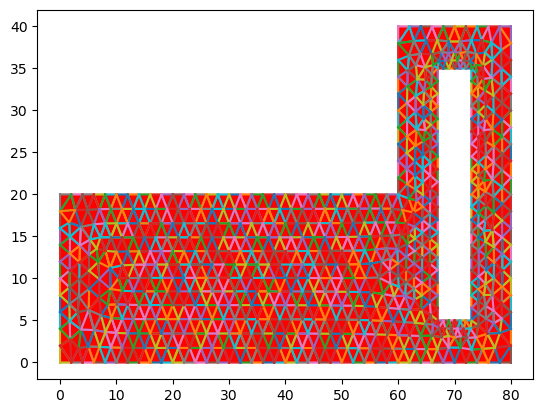

In [9]:
X = np.zeros([Num_Elems, 4])
Y = np.zeros([Num_Elems, 4])
CGX = np.zeros([Num_Elems, 1])
CGY = np.zeros([Num_Elems, 1])

for elem in range(1, Num_Elems+1,1):
    N1 = NCA[elem,3]
    N2 = NCA[elem,2]
    N3 = NCA[elem,1]
    X1N1 = COORD[N1,1]
    X2N1 = COORD[N1,2]
    X1N2 = COORD[N2,1]
    X2N2 = COORD[N2,2]
    X1N3 = COORD[N3,1]
    X2N3 = COORD[N3,2]
    Mat_Num = NCA[elem,4]
    X = [X1N1,X1N2,X1N3,X1N1]
    Y = [X2N1,X2N2,X2N3,X2N1]
    CGX[elem - 1] = (X1N1+X1N2+X1N3)/3.0
    CGY[elem - 1] = (X2N1+X2N2+X2N3)/3.0
    plt.plot(X, Y)
#     plt.scatter(X, Y)
    #plt.text(CGX[elem-1],CGY[elem-1],str(elem),bbox = dict(facecolor = 'white', alpha = 0.5))
    match NCA[elem , 4]:
        case 1:
            plt.fill(X, Y, color = 'red')
        case 2:
            plt.fill(X, Y, color = 'green')

#### Element Stiffness matrix and Assembly of Golbal Stiffness matrix

In [10]:
DOF_PN = 2
Total_DOF = Num_Nodes*DOF_PN
GSTIFF = np.zeros((Total_DOF,Total_DOF))
F = np.zeros((Total_DOF,1))

for elem in range(1, Num_Elems+1,1):
    N1 = NCA[elem,3]
    N2 = NCA[elem,2]
    N3 = NCA[elem,1]
    X1N1 = COORD[N1,1]
    X2N1 = COORD[N1,2]
    X1N2 = COORD[N2,1]
    X2N2 = COORD[N2,2]
    X1N3 = COORD[N3,1]
    X2N3 = COORD[N3,2]
    Two_Delta_matrix= np.array([[1, X1N1, X2N1],
                           [1, X1N2, X2N2],
                           [1, X1N3, X2N3]])
    Two_Delta = np.linalg.det(Two_Delta_matrix)
    Num_Nodes_PE = 3
    B = np.zeros((Num_Nodes_PE,Num_Nodes_PE*DOF_PN))
    B1 = (X2N2 - X2N3)
    B2 = (X2N3 - X2N1)
    B3 = (X2N1 - X2N2)
    G1 = (X1N3 - X1N2)
    G2 = (X1N1 - X1N3)
    G3 = (X1N2 - X1N1)
    B[0,0] = B1/Two_Delta
    B[0,2] = B2/Two_Delta
    B[0,4] = B3/Two_Delta
    B[1,1] = G1/Two_Delta
    B[1,3] = G2/Two_Delta
    B[1,5] = G3/Two_Delta
    B[2,0] = G1/Two_Delta
    B[2,1] = B1/Two_Delta
    B[2,2] = G2/Two_Delta
    B[2,3] = B2/Two_Delta
    B[2,4] = G3/Two_Delta
    B[2,5] = B3/Two_Delta
    Two_Delta_2 = np.linalg.det(Two_Delta_matrix)
    Mat_Num = NCA[elem,4]
    match Mat_Num:
        case 1:
            E = MAT[Mat_Num,1]
            PR = MAT[Mat_Num,2]
        case 2:
            E = MAT[Mat_Num,1]
            PR = MAT[Mat_Num,2]
    D = np.zeros((Num_Nodes_PE,Num_Nodes_PE))
    match Prob_Type:
        case 21:
            CONST = E/(1-PR**2)
            D[0,0] = 1*CONST
            D[0,1] = PR*CONST
            D[0,2] = 0*CONST
            D[1,0] = PR*CONST
            D[1,1] = 1*CONST
            D[1,2] = 0*CONST
            D[2,0] = 0*CONST
            D[2,1] = 0*CONST
            D[2,2] = 0.5*(1-PR)*CONST
        case 22:
            CONST = E/((1+PR)*(1-2*PR))
            D[0,0] = (1-PR)*CONST
            D[0,1] = PR*CONST
            D[0,2] = 0*CONST
            D[1,0] = PR*CONST
            D[1,1] = (1-PR)*CONST
            D[1,2] = 0*CONST
            D[2,0] = 0*CONST
            D[2,1] = 0*CONST
            D[2,2] = 0.5*(1-2*PR)*CONST
    ESTIFF = B.transpose()@D@B*Thickness*0.5*Two_Delta
    CN = [2*N1-2, 2*N1-1, 2*N2-2, 2*N2-1,2*N3-2, 2*N3-1]
    CN_IDX = np.array(6*CN).reshape(6,6)
    RO_IDX = CN_IDX.transpose()
    GSTIFF[RO_IDX,CN_IDX] = GSTIFF[RO_IDX,CN_IDX]+ESTIFF

#### Force Matrix

In [11]:
Num_load = 2
F = np.zeros((Total_DOF,1))

for i in range(1, Num_load+1,1):
    LOAD_TYPE = int(LOAD_BC[i,2])
    match LOAD_TYPE:
        case 1:
            N = int(LOAD_BC[i,1])
            F[2*N-2,0] = F[2*N-2,0]+ LOAD_BC[i,3]
        case 2:
            N = int(LOAD_BC[i,1])
            F[2*N-1,0] = F[2*N-1,0]+ LOAD_BC[i,4]
        case 12:
            N = int(LOAD_BC[i,1])
            F[2*N-2,0] = F[2*N-2,0]+ LOAD_BC[i,3]
            F[2*N-1,0] = F[2*N-1,0]+ LOAD_BC[i,4]

#### Solve [K] {u} = {F} and find Displacement {u}

In [12]:
GSTIFFCOPY = GSTIFF.copy()
Num_Disp_BC = 11
for i in range(1,Num_Disp_BC+1,1):
    DISP_TYPE = int(DISP_BC[i,2])
    match DISP_TYPE:
        case 1:
            N = int(DISP_BC[i,1])
            F[2*N-2,0] = F[2*N-2,0]+ DISP_BC[i,3]*10**32
            GSTIFFCOPY[2*N-2,2*N-2] = GSTIFFCOPY[2*N-2,2*N-2]+10**32
        case 2:
            N = int(DISP_BC[i,1])
            F[2*N-1,0] = F[2*N-1,0]+ DISP_BC[i,4]*10**32
            GSTIFFCOPY[2*N-1,2*N-1] = GSTIFFCOPY[2*N-1,2*N-1]+10**32
        case 12:
            N = int(DISP_BC[i,1])
            F[2*N-2,0] = F[2*N-2,0]+ DISP_BC[i,3]*10**32
            GSTIFFCOPY[2*N-2,2*N-2] = GSTIFFCOPY[2*N-2,2*N-2]+10**32
            F[2*N-1,0] = F[2*N-1,0]+ DISP_BC[i,4]*10**32
            GSTIFFCOPY[2*N-1,2*N-1] = GSTIFFCOPY[2*N-1,2*N-1]+10**32

In [13]:
DISP = np.linalg.solve(GSTIFFCOPY,F)
DISP_XY = DISP.reshape(-1, 2)
DISP_XY
np.savetxt('./DISPOUT',DISP_XY)

#### Equivalent Stress (Von-Mises Stress) Plot

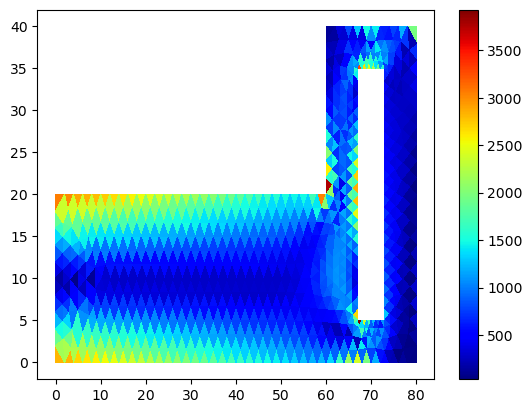

In [14]:
EQ_STRESS = np.zeros(Num_Elems+1)
for elem in range(1, Num_Elems+1,1):
    N1 = NCA[elem,3]
    N2 = NCA[elem,2]
    N3 = NCA[elem,1]
    X1N1 = COORD[N1,1]
    X2N1 = COORD[N1,2]
    X1N2 = COORD[N2,1]
    X2N2 = COORD[N2,2]
    X1N3 = COORD[N3,1]
    X2N3 = COORD[N3,2]
    Two_Delta_matrix= np.array([[1, X1N1, X2N1],
                           [1, X1N2, X2N2],
                           [1, X1N3, X2N3]])
    Two_Delta = np.linalg.det(Two_Delta_matrix)
    Num_Nodes_PE = 3
    B = np.zeros((Num_Nodes_PE,Num_Nodes_PE*DOF_PN))
    B1 = (X2N2 - X2N3)
    B2 = (X2N3 - X2N1)
    B3 = (X2N1 - X2N2)
    G1 = (X1N3 - X1N2)
    G2 = (X1N1 - X1N3)
    G3 = (X1N2 - X1N1)
    B[0,0] = B1/Two_Delta
    B[0,2] = B2/Two_Delta
    B[0,4] = B3/Two_Delta
    B[1,1] = G1/Two_Delta
    B[1,3] = G2/Two_Delta
    B[1,5] = G3/Two_Delta
    B[2,0] = G1/Two_Delta
    B[2,1] = B1/Two_Delta
    B[2,2] = G2/Two_Delta
    B[2,3] = B2/Two_Delta
    B[2,4] = G3/Two_Delta
    B[2,5] = B3/Two_Delta
    Two_Delta_2 = np.linalg.det(Two_Delta_matrix)
    Mat_Num = NCA[elem,4]
    match Mat_Num:
        case 1:
            E = MAT[Mat_Num,1]
            PR = MAT[Mat_Num,2]
        case 2:
            E = MAT[Mat_Num,1]
            PR = MAT[Mat_Num,2]
    D = np.zeros((Num_Nodes_PE,Num_Nodes_PE))
    match Prob_Type:
        case 21:
            CONST = E/(1-PR**2)
            D[0,0] = 1*CONST
            D[0,1] = PR*CONST
            D[0,2] = 0*CONST
            D[1,0] = PR*CONST
            D[1,1] = 1*CONST
            D[1,2] = 0*CONST
            D[2,0] = 0*CONST
            D[2,1] = 0*CONST
            D[2,2] = 0.5*(1-PR)*CONST
        case 22:
            CONST = E/((1+PR)*(1-2*PR))
            D[0,0] = (1-PR)*CONST
            D[0,1] = PR*CONST
            D[0,2] = 0*CONST
            D[1,0] = PR*CONST
            D[1,1] = (1-PR)*CONST
            D[1,2] = 0*CONST
            D[2,0] = 0*CONST
            D[2,1] = 0*CONST
            D[2,2] = 0.5*(1-2*PR)*CONST
    CN = [2*N1-2, 2*N1-1, 2*N2-2, 2*N2-1,2*N3-2, 2*N3-1]
    u = DISP[CN]
    STRAIN = B@u
    STRESS = D@STRAIN
    STRESS = STRESS.reshape(-1,3)
    STRESS_XX = STRESS[:,0]
    STRESS_YY = STRESS[:,1]
    STRESS_XY = STRESS[:,2]
    V = np.sqrt((STRESS_XX**2-(STRESS_XX*STRESS_YY))+(STRESS_YY**2)+(3*(STRESS_XY**2)))
    
    EQ_STRESS[elem] = V
    
XCOORD = COORD[1:, 1]
YCOORD = COORD[1:, 2]
ELEM_CON = NCA[1:,1:-1]-1
VonMises = EQ_STRESS[1:]
plt.tripcolor(XCOORD, YCOORD, ELEM_CON, VonMises, cmap='jet')
plt.colorbar()
plt.show()

#### Deformed shape Vs Un-deformed Shape Plot

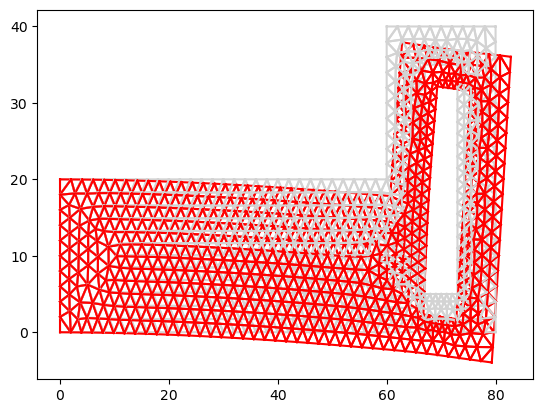

In [15]:
COORD_NEW = COORD[1:, [1,2]] + DISP_XY
for elem in range(1, Num_Elems+1,1):
    N1 = NCA[elem,3]
    N2 = NCA[elem,2]
    N3 = NCA[elem,1]
    
    X1N1 = COORD[N1,1]
    X2N1 = COORD[N1,2]
    X1N2 = COORD[N2,1]
    X2N2 = COORD[N2,2]
    X1N3 = COORD[N3,1]
    X2N3 = COORD[N3,2]
   
    X = [X1N1,X1N2,X1N3,X1N1]
    Y = [X2N1,X2N2,X2N3,X2N1]
    
    plt.plot(X, Y,  color='lightgrey')
    
    X1N1_NEW = COORD_NEW[N1-1,0]
    X2N1_NEW = COORD_NEW[N1-1,1]
    X1N2_NEW = COORD_NEW[N2-1,0]
    X2N2_NEW = COORD_NEW[N2-1,1]
    X1N3_NEW = COORD_NEW[N3-1,0]
    X2N3_NEW = COORD_NEW[N3-1,1]
    Mat_Num = NCA[elem, 4]
    X = [X1N1_NEW,X1N2_NEW,X1N3_NEW,X1N1_NEW]
    Y = [X2N1_NEW,X2N2_NEW,X2N3_NEW,X2N1_NEW]
    
    plt.plot(X, Y,  color='red')


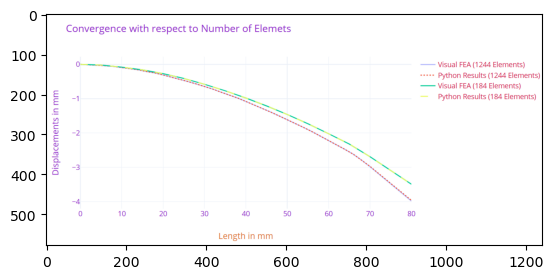

In [16]:
img2 = Image.open('Convergence.png')
plt.imshow(img2)